In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv('../1_pandas_analysis/dataset/telecom_churn.csv')
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


[Text(0, 0.5, 'Плотность вероятности'), Text(0.5, 0, 'Количество звонков')]

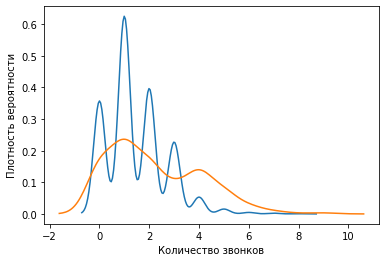

In [3]:
fig = sns.kdeplot(data[data['churn'] == False]['customer service calls'], label='Loyal')
fig = sns.kdeplot(data[data['churn'] == True]['customer service calls'], label='Churn')
fig.set(xlabel='Количество звонков', ylabel='Плотность вероятности')

Функция для генерации образцов бутстрэпом

In [4]:
def get_bootstrap_samples(data, n_samples):
    indexes = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indexes]
    return samples

Функция для интервальной оценки (границы внутри которых с заданной вероятностью мы попадаем)

In [5]:
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Разобем клиентов на лояльных и нет

In [6]:
loyal_clients = data[data['churn'] == False]['customer service calls'].values
churn_clients = data[data['churn'] == True]['customer service calls'].values

In [7]:
loyal_clients, np.mean(loyal_clients)

(array([1, 1, 0, ..., 2, 2, 0], dtype=int64), 1.4498245614035088)

Сгенерируем массивы из 1000 бутсрэпов по среднему кол-ву звонков в обоих классах

In [8]:
get_bootstrap_samples(loyal_clients, 3)

array([[3, 0, 2, ..., 2, 0, 2],
       [1, 1, 2, ..., 1, 0, 0],
       [1, 1, 4, ..., 2, 1, 1]], dtype=int64)

In [9]:
loyal_client_scores = [np.mean(sample) for sample in get_bootstrap_samples(loyal_clients, 1000)]
churn_clients_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn_clients, 1000)]

In [10]:
print("Service calls from loyal:  mean interval",  stat_intervals(loyal_client_scores, 0.05))
print("Service calls from churn:  mean interval",  stat_intervals(churn_clients_scores, 0.05))

Service calls from loyal:  mean interval [1.40876316 1.49266667]
Service calls from churn:  mean interval [2.06620083 2.39756729]


## Сравнение случайного леса с деревом и бэггингом

In [11]:
n_train = 150
n_test = 1000
noise = 0.1

Функция генерации данных

In [12]:
def f(X):
    X = X.ravel()
    return np.exp(-X ** 2) + 1.5 * np.exp(-(X-2) ** 2)

Функция генерации выборки

In [13]:
def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 -5
    X = np.sort(X).ravel()
    y = f(X) + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

In [16]:
X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)
X_train[:5], y_train[:5]

(array([[-4.97799457],
        [-4.94042864],
        [-4.91709006],
        [-4.90638871],
        [-4.85171221]]),
 array([ 0.14773846,  0.19828334,  0.21011355, -0.03815955,  0.01331419]))

In [42]:
def plot_results(X_train, y_train, X_test, y_test, y_predict):
    plt.figure(figsize=(10, 6))
    plt.plot(X_test, y_test, c='r')
    plt.scatter(X_train, y_train, c='b', s=20)
    plt.plot(X_test, y_predict, c='g', lw=2)
    plt.xlim([-5, 5])
    plt.title('MSE = %.4f' % float(np.sum((y_test - y_predict) ** 2)/len(y_test)))

### Дерево решений

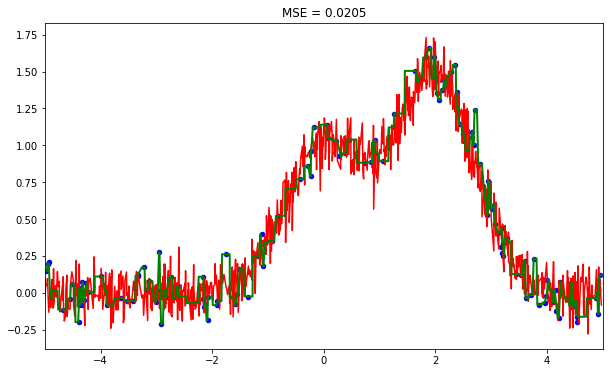

In [43]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)
tree_reg_predict = tree_reg.predict(X_test)

plot_results(X_train, y_train, X_test, y_test, tree_reg_predict)

### Дерево решений c бэггингом

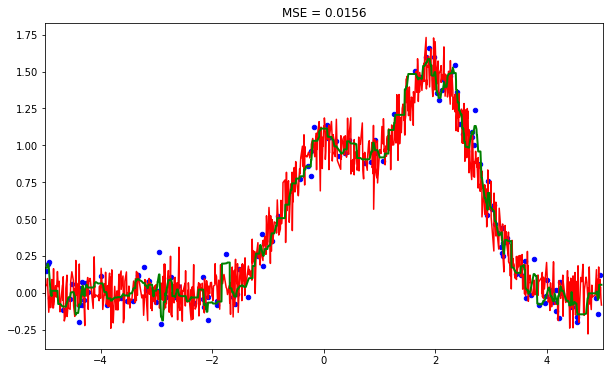

In [53]:
from sklearn.ensemble import BaggingRegressor

bagtree_reg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10).fit(X_train, y_train)
bagtree_reg_predict = bagtree_reg.predict(X_test)

plot_results(X_train, y_train, X_test, y_test, bagtree_reg_predict)

### Случайный лес

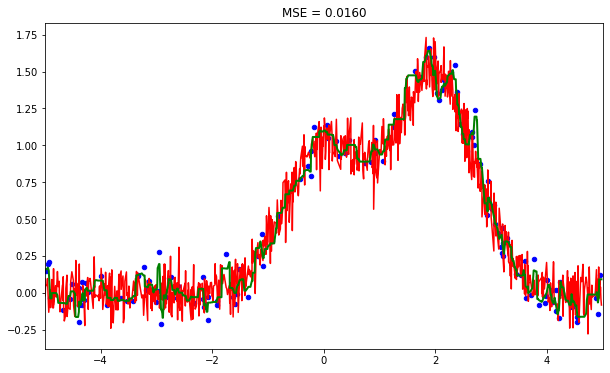

In [54]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_reg_predict = rf_reg.predict(X_test)

plot_results(X_train, y_train, X_test, y_test, rf_reg_predict)

## Сравнение в задаче классификации

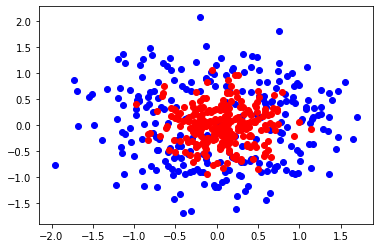

In [63]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=42)
X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(X, y, test_size=0.2)

plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='b')
plt.scatter(X[:, 0][y!=0], X[:, 1][y!=0], c='r')

In [64]:
def plot_results_clf(clf, X_train, y_train, X_test, y_test, y_predict):
    x_range = np.linspace(X_train.min(), X_train.max(), 100)
    xx1, xx2 = np.meshgrid(x_range, x_range)
    y_hat = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
    y_hat = y_hat.reshape(xx1.shape)
    plt.contourf(xx1, xx2, y_hat, alpha=0.2)
    plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')

### Дерево решений

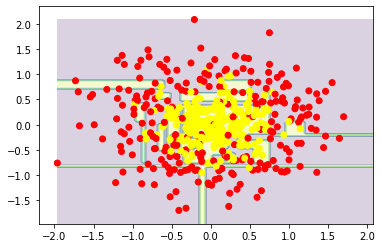

In [67]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42).fit(X_train_circles, y_train_circles)
tree_clf_predict = tree_clf.predict(X_test_circles)

plot_results_clf(tree_clf, X_train_circles, y_train_circles, X_test_circles, y_test_circles, tree_clf_predict)

### Дерево с бэггингом

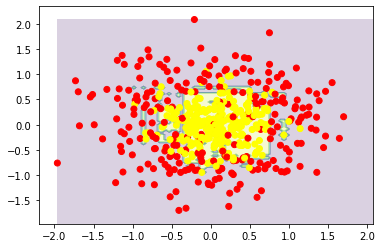

In [68]:
from sklearn.ensemble import BaggingClassifier

btree_clf = BaggingClassifier(DecisionTreeClassifier()).fit(X_train_circles, y_train_circles)
btree_clf_predict = btree_clf.predict(X_test_circles)

plot_results_clf(btree_clf, X_train_circles, y_train_circles, X_test_circles, y_test_circles, btree_clf_predict)

### Случайный лес

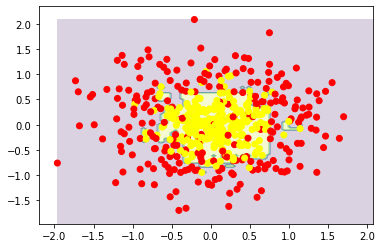

In [71]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100).fit(X_train_circles, y_train_circles)
rf_clff_predict = rf_clf.predict(X_test_circles)

plot_results_clf(rf_clf, X_train_circles, y_train_circles, X_test_circles, y_test_circles, rf_clff_predict)

## Параметры

### Рассмотрим применение случайного леса в реальной задаче 

In [74]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

Данные из задачи про отток клиентов

In [75]:
data = pd.read_csv('../1_pandas_analysis/dataset/telecom_churn.csv')
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
state                     3333 non-null object
account length            3333 non-null int64
area code                 3333 non-null int64
phone number              3333 non-null object
international plan        3333 non-null object
voice mail plan           3333 non-null object
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64

Выберем колонки с числовым типом данных

In [80]:
cols = []
for col in data.columns:
    if (data[col].dtype == 'float64') or (data[col].dtype == 'int64'):
        cols.append(col)

Выделим признаки и классы

In [81]:
X, y = data[cols].copy(), np.asarray(data['churn'], dtype='int8')

Инициализируем страифицированную разбивку нашего датасета для валидации

In [82]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Инициализируем классификатор на основе случайного леса

In [85]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=8, oob_score=True, n_estimators=10)

Обучение

In [86]:
results = cross_val_score(rf_clf, X, y, cv=skf)
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

c:\python\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\python\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\python\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\python\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\python\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("

CV accuracy score: 91.18%


c:\python\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\python\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


### Построим кривые валидации для подбора количества деревьев

Создаем списки для сохранения точности на тренировочном и тестовом датасете

In [88]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

In [92]:
for ntrees in trees_grid:
    rf_clf = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf_clf.fit(X_train, y_train)
        temp_train_acc.append(rf_clf.score(X_train, y_train))
        temp_test_acc.append(rf_clf.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

c:\python\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\python\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\python\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\python\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\python\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("

Best accuracy on CV is 92.41% with 100 trees


Text(0.5, 0, 'N_estimators')

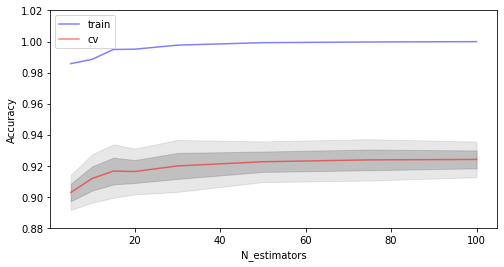

In [93]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

На тренировочном получили 100. Это говорит о переобучении. Нужна регуляризация

Настроим по глубине дерева

In [94]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.65% with 15 max_depth


Text(0.5, 0, 'Max_depth')

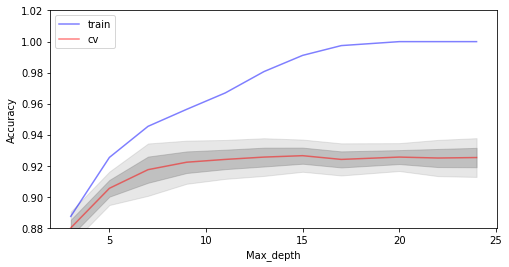

In [95]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")

Сделаем регуляризация по min_sample_leaf

In [96]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.41% with 1 min_samples_leaf


Text(0.5, 0, 'Min_samples_leaf')

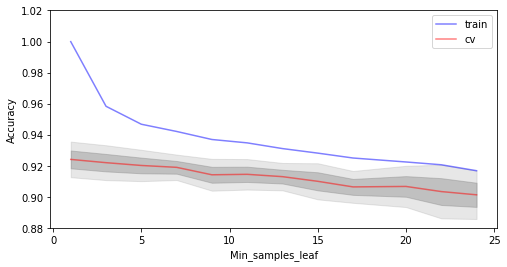

In [97]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf")

В данном случае мы не выигрываем в точности на валидации, но зато можем сильно уменьшить переобучение до 2% при сохранении точности около 92%.

Сделаем регуляризация по max_features

In [98]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.68% with 10 max_features


Text(0.5, 0, 'Max_features')

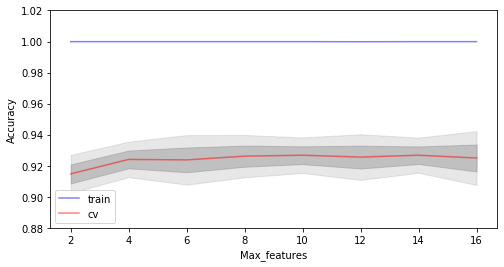

In [99]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features")

Сделаем перебор параметров через GridSearchCV

In [103]:
parameters = {
    'max_features': [4, 7, 10, 13],
    'min_samples_leaf': [1, 3, 5, 7],
    'max_depth': [5, 10, 15, 20]
}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=8)

grid_clf = GridSearchCV(rf_clf, parameters, n_jobs=8, cv=skf, verbose=-1)
grid_clf.fit(X, y)
grid_clf.best_score_

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   34.1s
[Parallel(n_jobs=8)]: Done 320 out of 320 | elapsed:   42.4s finished


0.9282928292829283